In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install numpy
# %pip install matplotlib
# %pip install nbformat
# %pip install opencv-python
# %pip install tensorflow
# %pip install wandb
# %pip install imblearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

import wandb
%env "WANDB_NOTEBOOK_NAME" "model_balanced_mobilenetv2.ipynb"

wandb.login()

from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="model_balanced_mobilenetv2.ipynb"


wandb: Currently logged in as: pedro-mariani (dspro2-group9). Use `wandb login --relogin` to force relogin


In [3]:
label_df = pd.read_csv(
    "../../../data/processed/combined/combined_label.csv", index_col=False
)
data_dir = "../../../data/processed/combined/img/"

label_df.head()

,image_name,expression_label
0,angry_0.jpg,angry
1,angry_1.jpg,angry
2,fear_2.jpg,fear
3,angry_4.jpg,angry
4,angry_5.jpg,angry


In [4]:
def load_data(dir_path, img_size):
    X = []
    y = []

    for index, row in label_df.iterrows():
        image_path = os.path.join(dir_path, row["image_name"])
        img = cv2.imread(image_path)
        img = (
            cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype("float32")
            / 255
        )
        X.append(img)
        y.append(row["expression_label"])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
IMG_SIZE = (96, 96)

X, y = load_data(data_dir, IMG_SIZE)

In [6]:
dummies = pd.get_dummies(label_df["expression_label"])
dummies.head()

,angry,disgust,fear,happy,neutral,sad,surprise
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [7]:
y = dummies.values
y

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [8]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(53676, 96, 96, 3)
(6710, 96, 96, 3)
(6710, 96, 96, 3)
(53676, 7)
(6710, 7)
(6710, 7)


# Distribution of classes in each set


In [9]:
class_count_in_train_set = np.sum(y_train, axis=0)

print("Class distribution:")
print(class_count_in_train_set)

Class distribution:
[6888 3659 4968 9521 9837 9942 8861]


In [10]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [11]:
X_train.shape

(53676, 96, 96, 3)

In [12]:
# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_train_reshaped = X_train.reshape(n_samples, n_channels * height * width)

In [13]:
# initialize the SMOTE model
smote = SMOTE(random_state=62)

# perform re-sampling on modified X given y
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)

In [14]:
class_count_in_train_smote_set = np.sum(y_train_smote, axis=0)

print("Class distribution:")
print(class_count_in_train_set)

Class distribution:
[6888 3659 4968 9521 9837 9942 8861]


In [15]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_train_smote_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set after SMOTE",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [16]:
class_count_in_validation_set = np.sum(y_valid, axis=0)

print("Class distribution:")
print(class_count_in_validation_set)

Class distribution:
[ 869  444  604 1179 1243 1240 1131]


In [17]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_validation_set, color=labels)

fig.update_layout(
    title="Distribution of each label in validation set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [18]:
class_count_in_test_set = np.sum(y_test, axis=0)

print("Class distribution:")
print(class_count_in_test_set)

Class distribution:
[ 867  439  637 1158 1244 1295 1070]


In [19]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_test_set, color=labels)

fig.update_layout(
    title="Distribution of each label in test set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [20]:
X_train_smote = X_train_smote.reshape(len(X_train_smote), 96, 96, 3)

In [21]:
X_train_smote.shape

(69594, 96, 96, 3)

In [22]:
y_train_smote.shape

(69594, 7)

# Data augmentation to balance the dataset


In [23]:
# # Assume x_train and y_train are your original data
# # Create an ImageDataGenerator with desired augmentations
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     brightness_range=(0.8, 1.2),
#     zoom_range=0.1,
# )

# # Generate augmented images for the minority class
# angry_indices = np.where(y_train_smote[:, 0] == 1)[0]
# disgust_indices = np.where(y_train_smote[:, 1] == 1)[0]
# fear_indices = np.where(y_train_smote[:, 2] == 1)[0]
# augmented_angry_images = datagen.flow(
#     X_train_smote[angry_indices], y_train_smote[angry_indices], batch_size=len(angry_indices)
# )
# augmented_disgust_images = datagen.flow(
#     X_train_smote[disgust_indices], y_train_smote[disgust_indices], batch_size=len(disgust_indices)
# )
# augmented_fear_images = datagen.flow(
#     X_train_smote[fear_indices], y_train_smote[fear_indices], batch_size=len(fear_indices)
# )

# # Combine augmented minority class images with original data
# x_train_balanced = np.concatenate(
#     [
#         X_train_smote,
#         augmented_angry_images[0][0],
#         augmented_disgust_images[0][0],
#         augmented_fear_images[0][0],
#     ]
# )
# y_train_balanced = np.concatenate(
#     [
#         y_train_smote,
#         augmented_angry_images[0][1],
#         augmented_disgust_images[0][1],
#         augmented_fear_images[0][1],
#     ]
# )

In [24]:
class_count_in_balanced_train_set = np.sum(y_train_smote, axis=0)

print("Class distribution:")
print(class_count_in_balanced_train_set)

Class distribution:
[9942 9942 9942 9942 9942 9942 9942]


In [25]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_balanced_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in balanced train set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Model training


In [26]:
IMG_SIZE = (96, 96)

base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

In [27]:
NUM_CLASSES = 7

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [28]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",
    name="mobileNetV2_smote_epoch10_40_batch128",
    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metric": ["categorical_accuracy"],
        "epoch_frozen": 10,
        "epoch_unfrozen": 40,
        "batch_size": 128,
        "architecture": "MobileNetV2",
        "dropout": 0.4,
        "learning_rate": 0.0003,
        "Dense": 512,
        "IMG_SIZE": "96, 96",
        # "initial_training": "5 Epochs",
        # "retraining": "20 epochs"
    },
)

In [29]:
config = wandb.config


model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=0.0003),
    metrics=config["metric"],
)

history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_valid, y_valid),
    epochs=config["epoch_frozen"],
    batch_size=config["batch_size"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

Epoch 1/10


wandb: ERROR Unable to log learning rate.


544/544 ━━━━━━━━━━━━━━━━━━━━ 93s 166ms/step - categorical_accuracy: 0.3044 - loss: 1.9388 - val_categorical_accuracy: 0.3869 - val_loss: 1.5865
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 91s 167ms/step - categorical_accuracy: 0.4136 - loss: 1.5306 - val_categorical_accuracy: 0.4004 - val_loss: 1.5634
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 96s 176ms/step - categorical_accuracy: 0.4559 - loss: 1.4390 - val_categorical_accuracy: 0.4036 - val_loss: 1.5425
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 94s 173ms/step - categorical_accuracy: 0.4880 - loss: 1.3544 - val_categorical_accuracy: 0.4104 - val_loss: 1.5474
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 96s 176ms/step - categorical_accuracy: 0.5157 - loss: 1.2787 - val_categorical_accuracy: 0.4238 - val_loss: 1.5103
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 93s 171ms/step - categorical_accuracy: 0.5551 - loss: 1.1905 - val_categorical_accuracy: 0.4210 - val_loss: 1.5186
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 93s 171ms/step - categorical_accuracy: 0.

In [30]:
base_model.trainable = True

In [31]:
model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=0.0003),
    metrics=config["metric"],
)

history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_valid, y_valid),
    epochs=config["epoch_unfrozen"],
    batch_size=config["batch_size"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

wandb.finish()

Epoch 1/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 483s 860ms/step - categorical_accuracy: 0.3298 - loss: 1.8544 - val_categorical_accuracy: 0.3477 - val_loss: 1.8050
Epoch 2/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 462s 850ms/step - categorical_accuracy: 0.5203 - loss: 1.2932 - val_categorical_accuracy: 0.3461 - val_loss: 1.9636
Epoch 3/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 455s 836ms/step - categorical_accuracy: 0.5909 - loss: 1.1067 - val_categorical_accuracy: 0.3994 - val_loss: 1.6923
Epoch 4/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 451s 829ms/step - categorical_accuracy: 0.6492 - loss: 0.9609 - val_categorical_accuracy: 0.3541 - val_loss: 2.0953
Epoch 5/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 446s 821ms/step - categorical_accuracy: 0.6963 - loss: 0.8411 - val_categorical_accuracy: 0.2569 - val_loss: 3.9715
Epoch 6/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 449s 825ms/step - categorical_accuracy: 0.7369 - loss: 0.7308 - val_categorical_accuracy: 0.3846 - val_loss: 2.8097
Epoch 7/40
544/544 ━━━━━━━━━━━━━━━━━━━━ 449s 826ms/step - catego

batch/batch_step,▁▁▁▂▂▂▂▃▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/categorical_accuracy,▁▂▂▃▃▄▄▅▁▃▄▅▅▆▇▇▇▇▇█▇▇██████████████████
batch/loss,█▇▇▆▆▅▅▄█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,▁▂▂▃▃▄▄▄▂▃▄▄▅▆▆▆▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
epoch/loss,█▇▇▆▆▅▅▅▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▃▃▄▄▄▄▅▅▁▁▃▁▃▃▅▄▆▅▇▆▇▇▆█▇▆▆██▇▇▇▇▆▇████▄
epoch/val_loss,▁▁▁▁▁▁▁▁▂▂▂▃▅▃▄▄▄▅▄▅▇▅▆▆▆▅▇▇▇▇▇▇█▇▇▆▆▇█▇
batch/batch_step,21795
batch/categorical_accuracy,0.96833
batch/loss,0.09342


In [32]:
model.save("../../../model/240531_mobilenetv2_smote_model.keras")

In [33]:
y_pred = model.predict(X_valid)
true_class = tf.argmax(y_valid, 1)
predicted_class = tf.argmax(y_pred, 1)

210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step


[Text(0, 0.5, 'angry'),
 Text(0, 1.5, 'disgust'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'happy'),
 Text(0, 4.5, 'neutral'),
 Text(0, 5.5, 'sad'),
 Text(0, 6.5, 'surprise')]

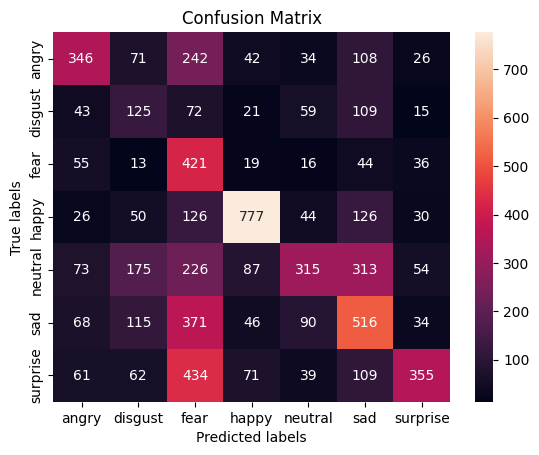

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_class, predicted_class)


ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt="g", ax=ax)


# labels, title and ticks

ax.set_xlabel("Predicted labels")

ax.set_ylabel("True labels")

ax.set_title("Confusion Matrix")

ax.xaxis.set_ticklabels(

    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)

ax.yaxis.set_ticklabels(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"])